In [27]:
import os
import numpy as np
from PIL import Image, ImageChops, ImageEnhance, ImageDraw
from io import BytesIO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow.keras.losses

In [28]:
IMAGE_SIZE = (128, 128)
SOURCE_FOLDER = 'dataset/images'
LABELS_FOLDER = 'dataset/labels'
SAMPLE_LIMIT = 1500

In [29]:
ELA_OUTPUT_FOLDER = 'dataset/ela_outputs'
MASK_OUTPUT_FOLDER = 'dataset/mask_outputs'
os.makedirs(ELA_OUTPUT_FOLDER, exist_ok=True)
os.makedirs(MASK_OUTPUT_FOLDER, exist_ok=True)

In [30]:
def load_and_preprocess_image(image_path, target_size=IMAGE_SIZE):
    """
    Load an image, convert to RGB, resize, and normalize.
    """
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size)
    return np.array(image) / 255.0

In [31]:
def generate_ela_image(image, quality=98):
    """
    Generate an Error Level Analysis (ELA) image from a PIL image.
    Uses an in-memory buffer.
    """
    buffer = BytesIO()
    image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    temp_image = Image.open(buffer)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

In [32]:
def create_mask(image_path, label_path, target_size=IMAGE_SIZE):
    """
    Create a binary mask from a YOLO-format label file.
    Assumes each label file contains lines in the format:
      class_id x_center y_center width height
    where the coordinates are normalized.
    """
    # Open the original image to get its original dimensions.
    img = Image.open(image_path)
    orig_width, orig_height = img.size
    
    # Create a black background mask in grayscale mode.
    mask = Image.new('L', (orig_width, orig_height), 0)
    draw = ImageDraw.Draw(mask)
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 5:
                continue
            try:
                # YOLO format: class_id, x_center, y_center, width, height (all normalized)
                _, x_center, y_center, w, h = parts
                x_center = float(x_center) * orig_width
                y_center = float(y_center) * orig_height
                w = float(w) * orig_width
                h = float(h) * orig_height
                x_min = x_center - w / 2
                y_min = y_center - h / 2
                x_max = x_center + w / 2
                y_max = y_center + h / 2
                # Draw a white filled rectangle for the bounding box.
                draw.rectangle([x_min, y_min, x_max, y_max], fill=255)
            except Exception as e:
                print("Error parsing YOLO label:", line, e)
    
    # Resize the mask to the target size and normalize to [0, 1]
    mask = mask.resize(target_size)
    mask = np.array(mask) / 255.0
    # Stack the mask to 3 channels if needed.
    mask = np.stack([mask, mask, mask], axis=-1)
    return mask

In [33]:
x1_data = []  # Original images
x2_data = []  # ELA images
y_data = []   # Masks


In [34]:
for file_name in image_files:
    image_path = os.path.join(SOURCE_FOLDER, file_name)
    # Assume the corresponding label file has the same basename with a .txt extension.
    label_file = os.path.splitext(file_name)[0] + '.txt'
    label_path = os.path.join(LABELS_FOLDER, label_file)
    
    # Load original image as a PIL image
    original_pil = Image.open(image_path).convert('RGB')
    
    # Generate the corresponding ELA image
    ela_pil = generate_ela_image(original_pil)
    
    # Save the ELA image in the ELA output folder (using the same file name)
    ela_save_path = os.path.join(ELA_OUTPUT_FOLDER, file_name)
    ela_pil.save(ela_save_path)
    
    # Create the mask from the bounding box labels
    mask = create_mask(image_path, label_path, target_size=IMAGE_SIZE)
    
    # Save the mask in the mask output folder (use _mask suffix)
    mask_save_path = os.path.join(MASK_OUTPUT_FOLDER, os.path.splitext(file_name)[0] + '_mask.png')
    # Convert the normalized mask back to 8-bit image format for saving.
    mask_to_save = Image.fromarray((mask * 255).astype(np.uint8))
    mask_to_save.save(mask_save_path)
    
    # Preprocess the images for model training (resize and normalize)
    original_img = original_pil.resize(IMAGE_SIZE)
    ela_img = ela_pil.resize(IMAGE_SIZE)
    original_img = np.array(original_img) / 255.0
    ela_img = np.array(ela_img) / 255.0
    
    x1_data.append(original_img)
    x2_data.append(ela_img)
    y_data.append(mask)

print(f"ELA images saved in: {ELA_OUTPUT_FOLDER}")
print(f"Masks saved in: {MASK_OUTPUT_FOLDER}")

ELA images saved in: dataset/ela_outputs
Masks saved in: dataset/mask_outputs


In [35]:
x1_data = np.array(x1_data)
x2_data = np.array(x2_data)
y_data = np.array(y_data)

In [36]:
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(
    x1_data, x2_data, y_data, test_size=0.2, random_state=42
)

print(f"Training samples: {len(x1_train)}, Testing samples: {len(x1_test)}")

Training samples: 1200, Testing samples: 300


In [37]:
custom_objects = {"mse": tensorflow.keras.losses.MeanSquaredError()}
model = load_model("../image_reconstruction_model.h5", custom_objects=custom_objects)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_X1            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_X2            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 128, 128,  │      1,792 │ Input_X1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 128, 128,  │      1,792 │ Input_X2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 64, 64,    │          0 │ conv2d_72[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 64, 64,    │          0 │ conv2d_74[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_26… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_28… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 32, 32,    │          0 │ conv2d_73[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 32, 32,    │          0 │ conv2d_75[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 131072)    │          0 │ max_pooling2d_27… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 131072)    │          0 │ max_pooling2d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 262144)    │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │ 67,109,120 │ concatenate_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    131,584 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 131072)    │ 67,239,936 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 32, 32,    │          0 │ dense_8[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 32, 32,    │    147,584 │ reshape_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 134,855,045 (514.43 MB)

 Trainable params: 134,855,043 (514.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [38]:
predictions = model.predict([x1_test, x2_test])

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step


In [45]:
from sklearn.metrics import f1_score, roc_auc_score, jaccard_score

y_true_channel = y_test[..., 0]
y_pred_channel = predictions[..., 0]

# Flatten the arrays to compute pixel-wise metrics.
y_true_flat = y_true_channel.flatten()
y_pred_prob_flat = y_pred_channel.flatten()

# Threshold both the ground truth and predictions.
y_true_bin_flat = (y_true_flat > 0.5).astype(np.uint8)
y_pred_bin_flat = (y_pred_prob_flat > 0.5).astype(np.uint8)

# Compute F1 score, AUC score, and IoU (Jaccard score)
f1 = f1_score(y_true_bin_flat, y_pred_bin_flat)
try:
    auc = roc_auc_score(y_true_bin_flat, y_pred_prob_flat)
except ValueError as e:
    auc = None
    print("AUC computation error:", e)
iou = jaccard_score(y_true_bin_flat, y_pred_bin_flat)

print("F1 Score: ", f1)
if auc is not None:
    print("AUC Score: ", auc)
print("IoU Score: ", iou)

F1 Score:  0.015041533635607843
AUC Score:  0.4859951437876639
IoU Score:  0.007577757363940012


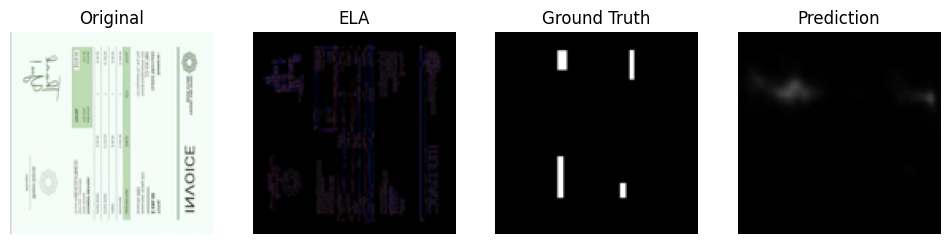

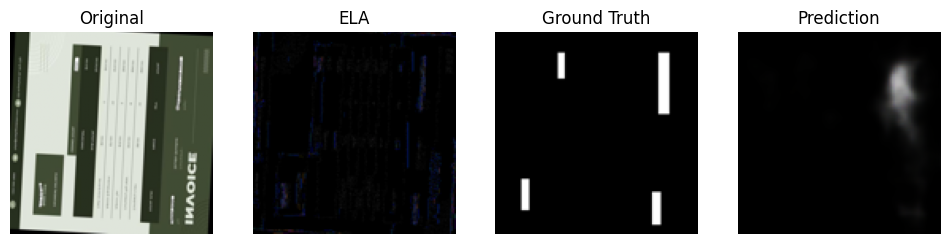

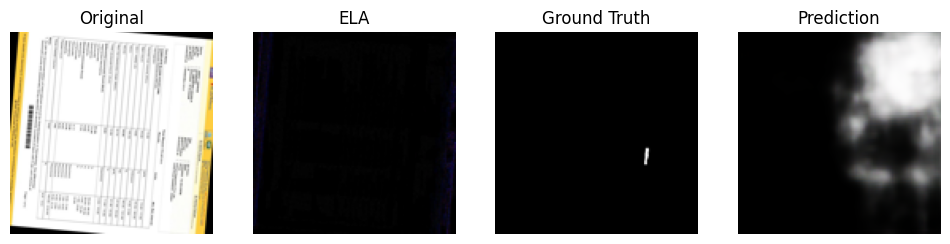

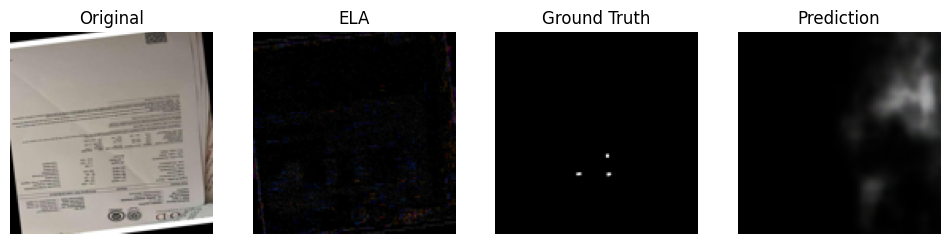

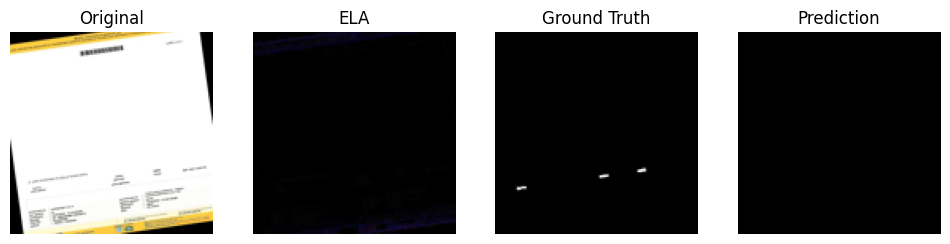

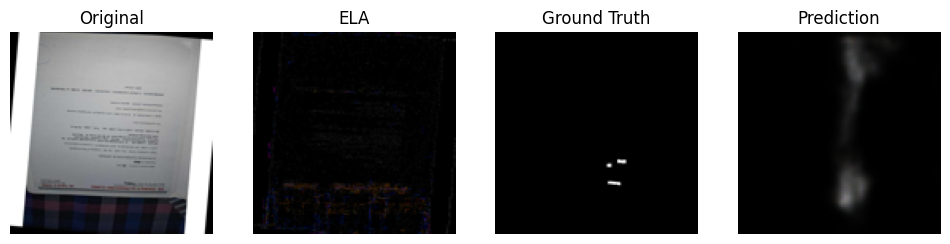

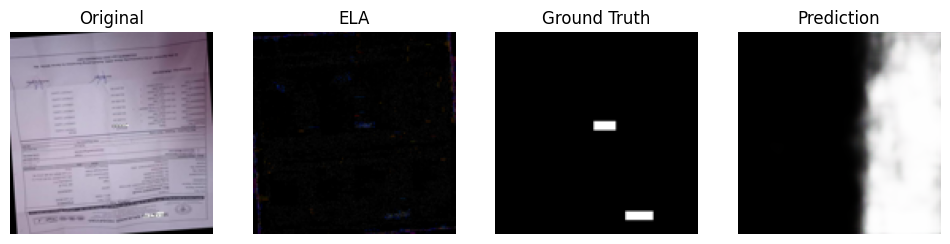

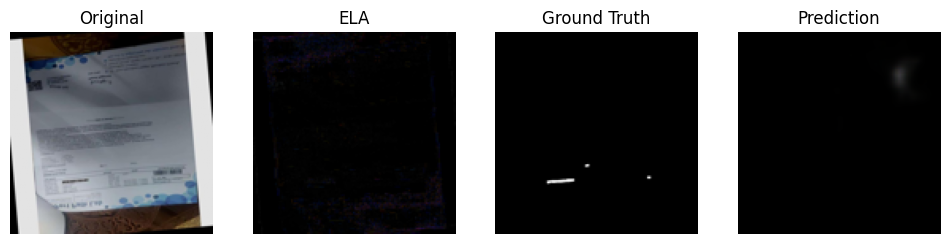

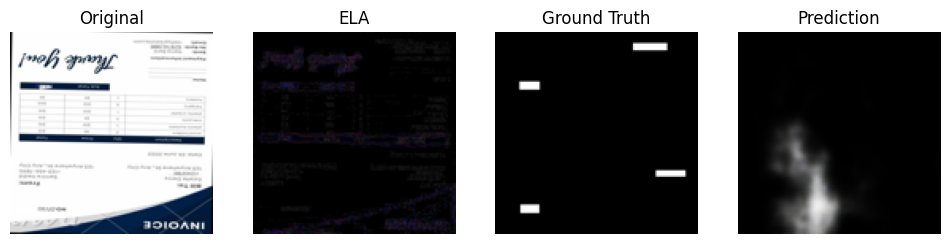

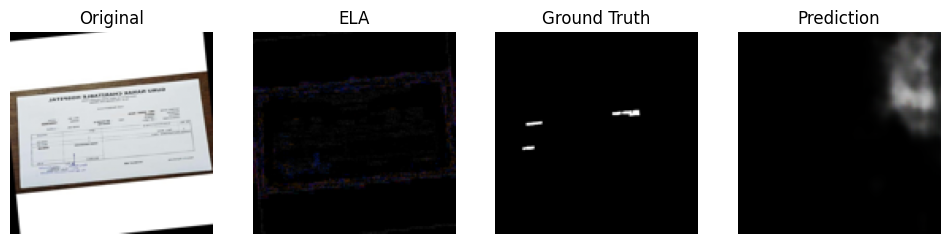

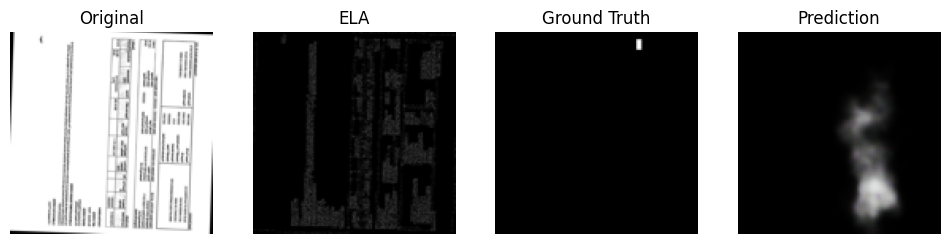

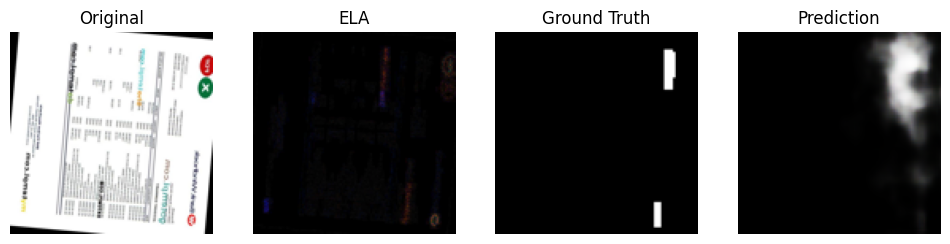

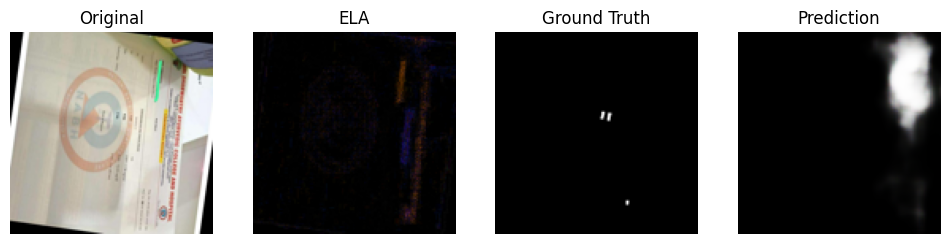

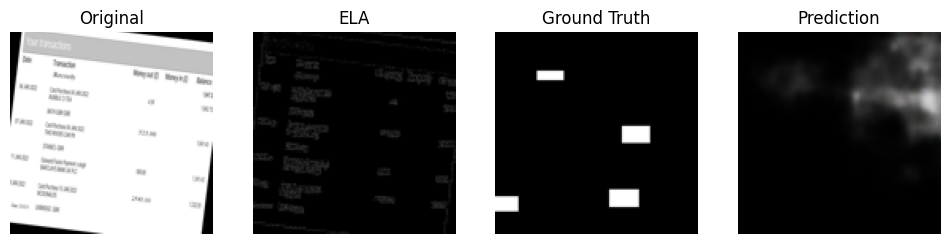

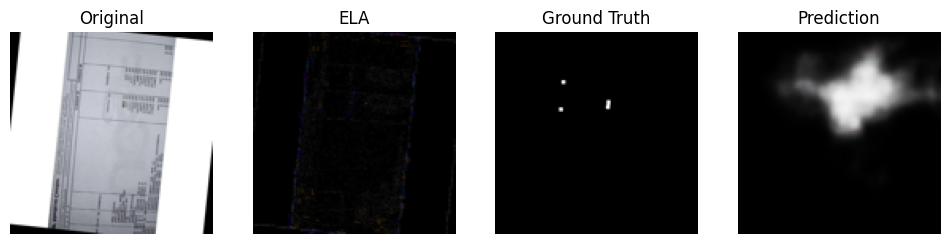

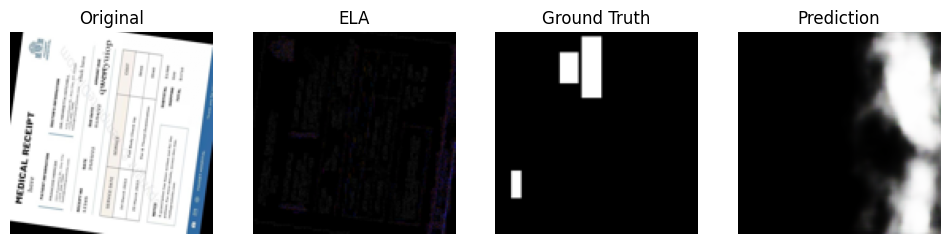

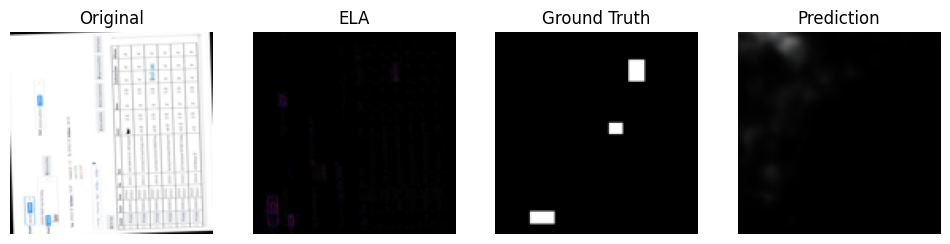

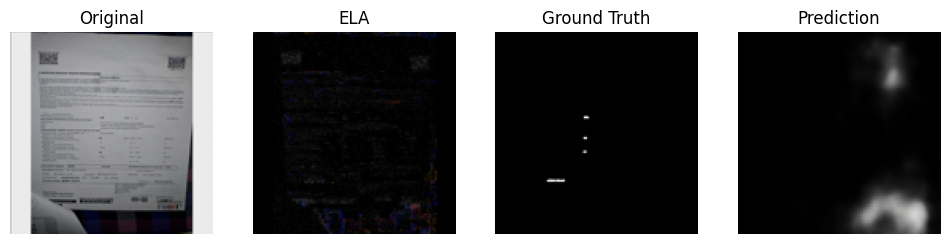

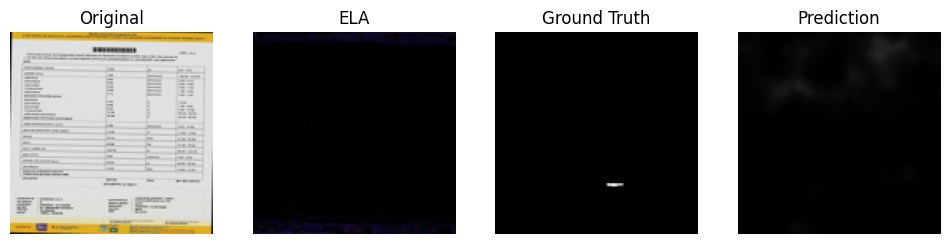

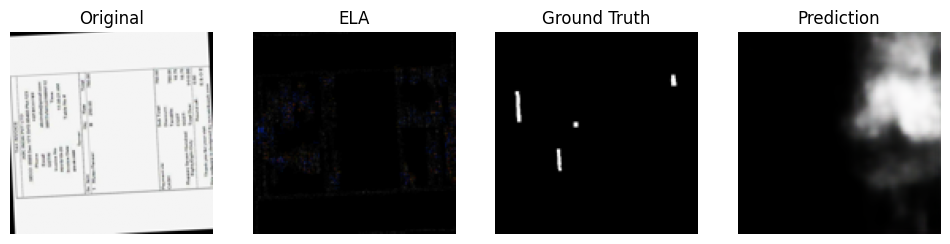

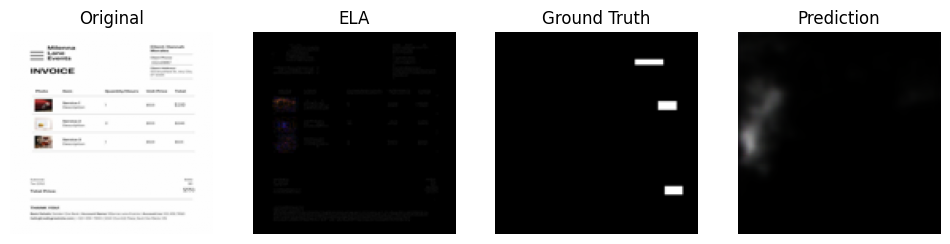

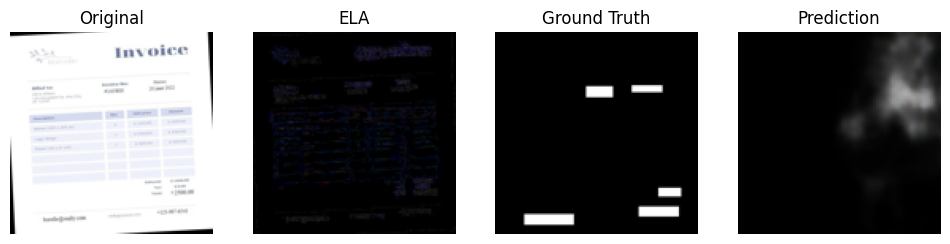

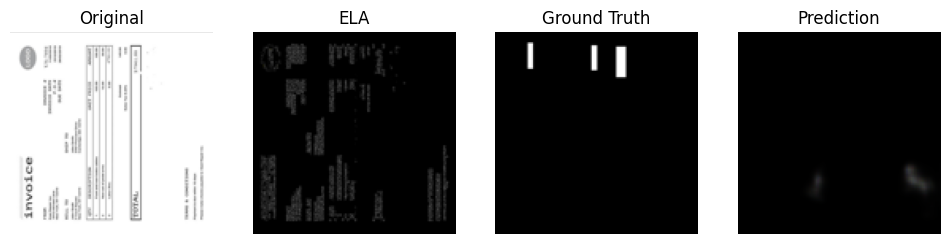

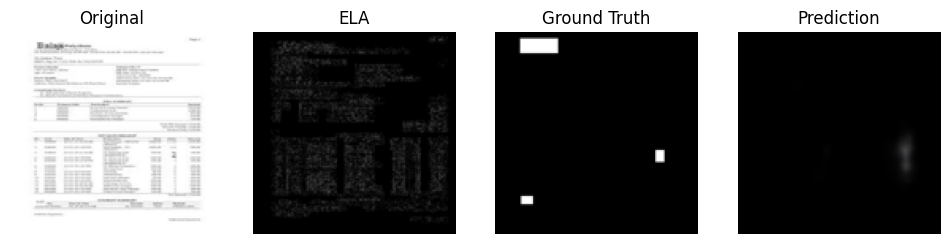

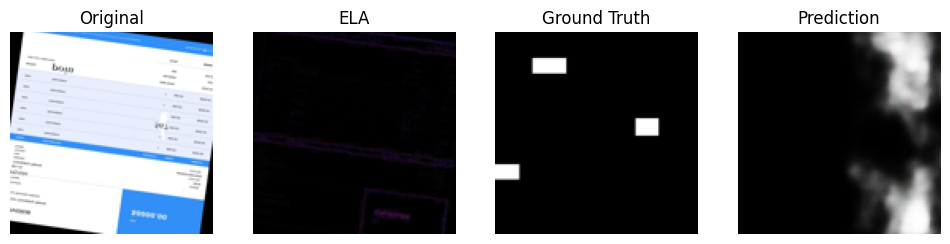

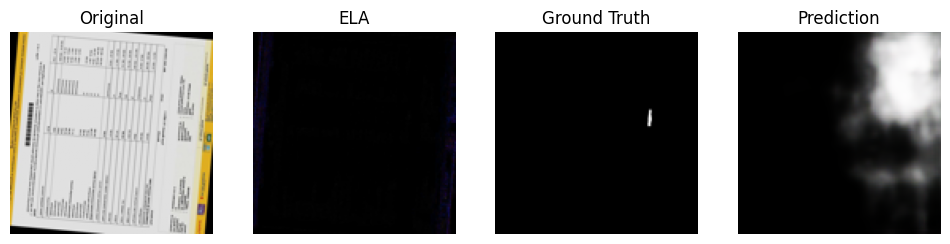

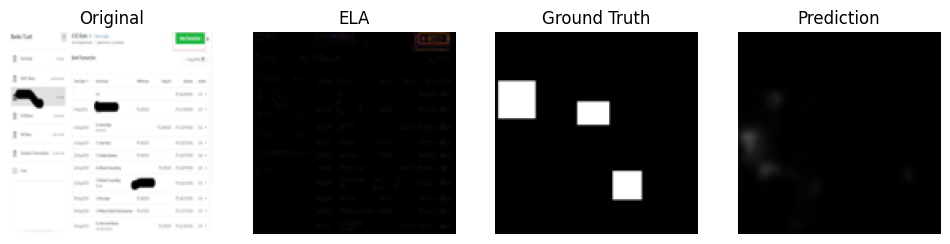

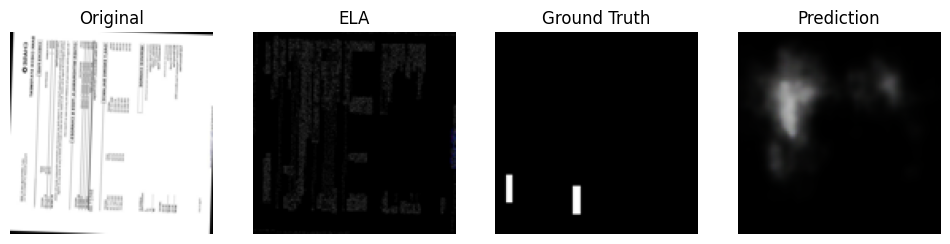

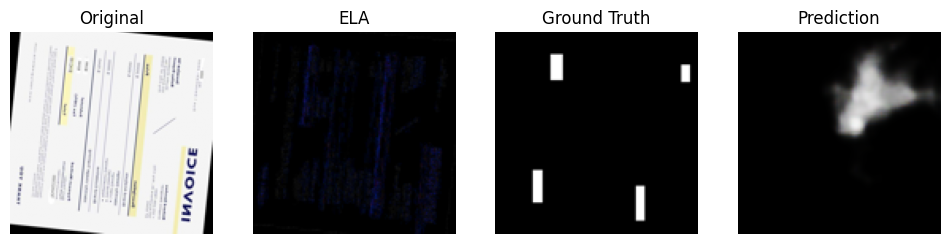

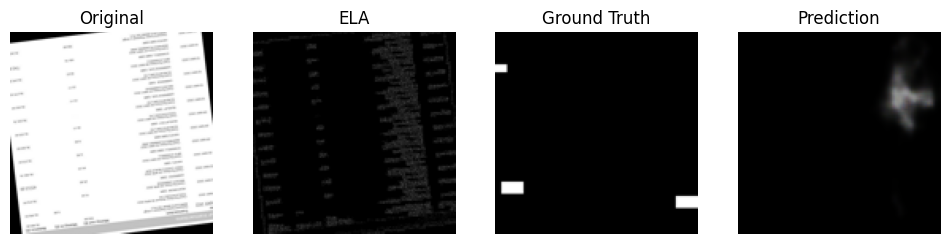

In [ ]:
num_display = 30
for i in range(num_display):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(x1_test[i])
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(x2_test[i])
    plt.title("ELA")
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(y_test[i])
    plt.title("Ground Truth")
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(predictions[i])
    plt.title("Prediction")
    plt.axis('off')
    
    plt.show()